In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import gzip
import numpy as np
from chissl import chissl_mongo as cm
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
# Download data at https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion
PATH = '''data/fashion-mnist'''

In [4]:
def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

images, labels = load_mnist(os.path.expanduser(PATH))

names = np.array(['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots'])

df = pd.DataFrame({
    'features': images.tolist(),
    'ground truth': names[labels],
    '_id': np.arange(len(images)).astype('str')
})

df.head()

,features,ground truth,_id
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ankle_boots,0
1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, 5...",t_shirt_top,1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0,...",t_shirt_top,2
3,"[0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64,...",dress,3
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",t_shirt_top,4


In [5]:
from chissl import image
from PIL import Image

df['src'] = df.features\
    .apply(lambda x: 255 - np.array(x, dtype=np.uint8).reshape((28, 28)))\
    .apply(Image.fromarray, mode='L')\
    .apply(Image.Image.resize,
           size=(75, 75),
           resample=Image.BICUBIC)\
    .apply(image.img2base64)

df.head()

,features,ground truth,_id,src
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ankle_boots,0,"{'type': 'image/png', 'data': 'iVBORw0KGgoAAAA..."
1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, 5...",t_shirt_top,1,"{'type': 'image/png', 'data': 'iVBORw0KGgoAAAA..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0,...",t_shirt_top,2,"{'type': 'image/png', 'data': 'iVBORw0KGgoAAAA..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64,...",dress,3,"{'type': 'image/png', 'data': 'iVBORw0KGgoAAAA..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",t_shirt_top,4,"{'type': 'image/png', 'data': 'iVBORw0KGgoAAAA..."


In [6]:
from chissl import chissl_mongo as cm
chissl = cm.ChisslMongo(verbose=True)

In [7]:
chissl.create_collection('Fashion', df.to_dict(orient='records'), drop=True)

In [8]:
cm.ChisslMongo(verbose=True)\
    .create_application('Fashion',
                          'Fashion',
                          'ImageComponent',
                          'chissl.pipelines.mnist.SimplePipeline',
                          drop=True)

{'_id': 'Fashion',
 'collection': 'Fashion',
 'component': 'ImageComponent',
 'pipeline': 'chissl.pipelines.mnist.SimplePipeline',
 'props': {},
 'params': {}}

In [9]:
obj = chissl.create_model('Fashion',
                          'test', drop=True)

Finding application <Fashion>...OK
Querying collection <Fashion> <None>...found 60000...OK
Transforming data...Pipeline(memory=None,
     steps=[('extract', <chissl.pipelines.mnist.JSONFeatureExtractor object at 0x1a34d1a2e8>), ('nmf', NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=30, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0))])...OK
Clustering data...OK
done.


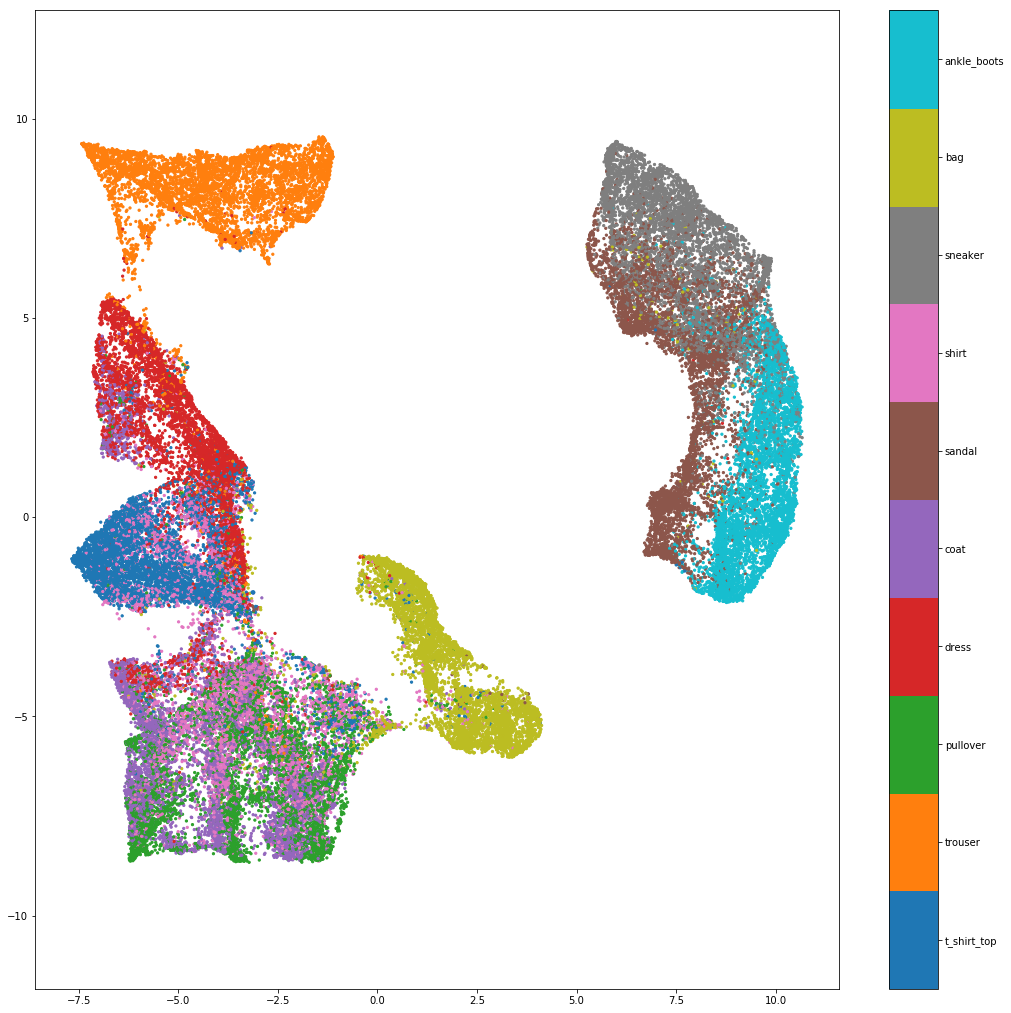

In [10]:
plt.figure(figsize=(18, 18))
plt.scatter(*np.array(obj['X']).T, s=5, c=labels, cmap='tab10', vmax=10)
plt.axis('equal')
cb = plt.colorbar()
cb.set_ticks(np.arange(10) + .5)
cb.set_ticklabels(names)